

<h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 30px; color: #081c15; text-align: center; line-height: 1.25;"><br><span style="color: #1b4332; font-size: 48px"><b>Movies Recommendation System</b></span><br><span style="color: #52b788; font-size: 20px">Using Content-Based and Deep Learning Approaches</span></h1>
<hr>

<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Table of Contents</p>

**In this notebook, we will cover:**
* [Overview](#0)
* [Exploratory Data Analysis](#1)
* [Recommender System](#2)
    1. [Content-Based Recommendation](#3)
    2. [Deep Learning (Tensorflow)](#4)

<a id=0 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Overview</p>

Recommender system is essentially a system/model/algoritm intended to give suggestion of relevant items to the users. It can be movie, music, and many more. Generally speaking, when it comes to the relation between users and service providers or buyers and e-commerce, recommendations will be extremely needed. In the end, decent recommendations will be a win-win solution that benefits both parties as the users are more royal because they got what they wanted and the service providers gained more profit. You may think, how impactful  those recommendations are? in fact, it's massive.

According to McKindsey, recommendations plays a crucial role in:
* **40%** of app installs on Google Play
* **60%** of watch time on Youtube
* **35%** of puchase on Amazon
* **75%** of movies watched on Netflix

Throughout this notebook, we will use 2 methods to build a movie recommender system which are content recommendation and deep learning using tensorflow framework

####

<a id=1 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Exploratory Data Analysis</p>

First thing first, there's always an EDA to give us a sense of what data we are dealing with. It's also useful to acquire some insights, informations, and even mistakes from data

In [ ]:
!pip install -q tensorflow-recommenders

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.34.0 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 24.3.25 which is incompatible.


In [ ]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [ ]:
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [ ]:
# Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 1</b></h1>

(0.0, 2.0, 0.9, 1.2)

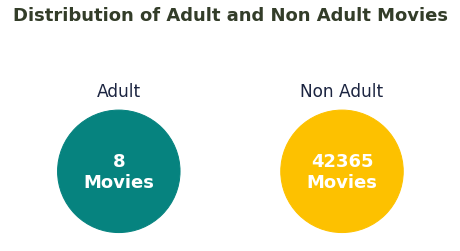

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* There is a huge difference between those 2 types of movies in terms of presence for this particular dataset

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 2</b></h1>

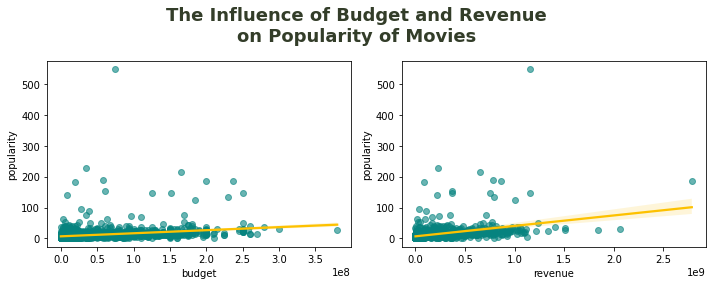

In [ ]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Budget and Revenue just slighly influence the popularity of the movies

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 3</b></h1>

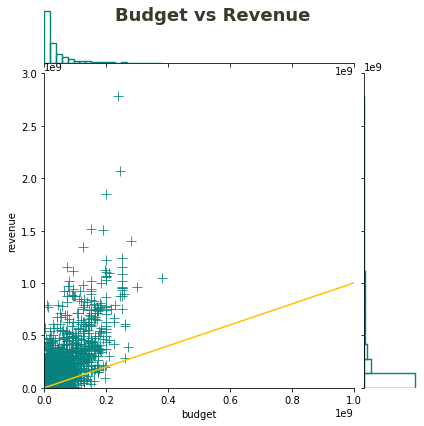

In [ ]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Most of the movies lay on top of the yellow line, indicate that those movies make a profit

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 4</b></h1>

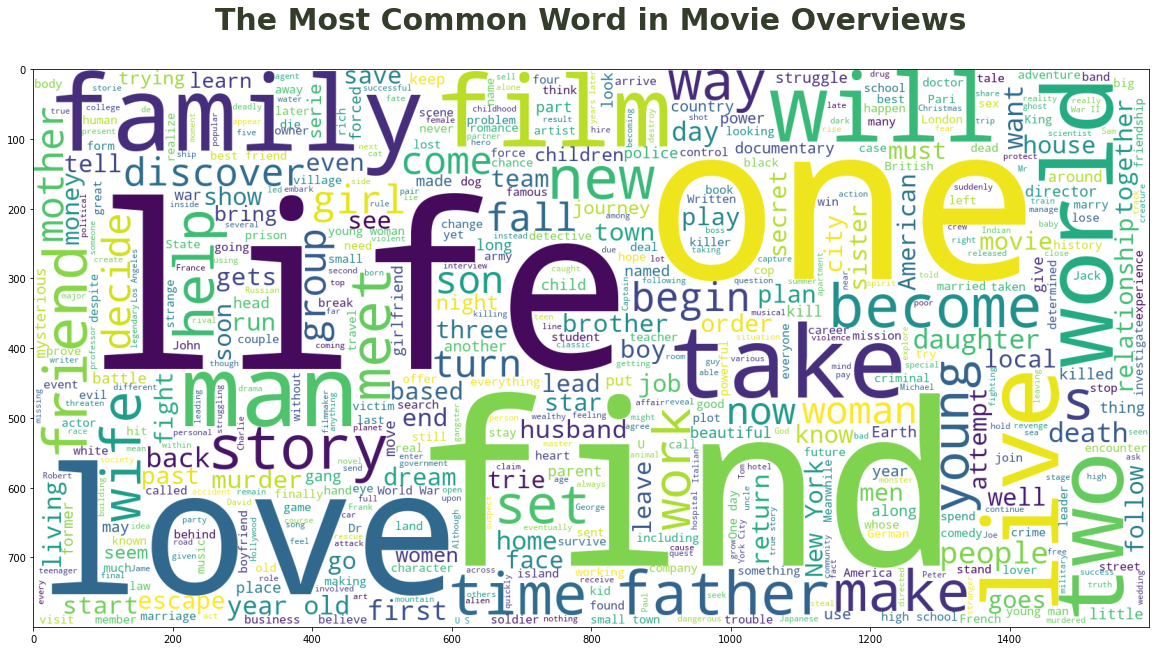

In [ ]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Word "life", "one", "find", "love" apparently appear in many occasions

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 5</b></h1>

(-1.25, 1.25, -1.25, 1.25)

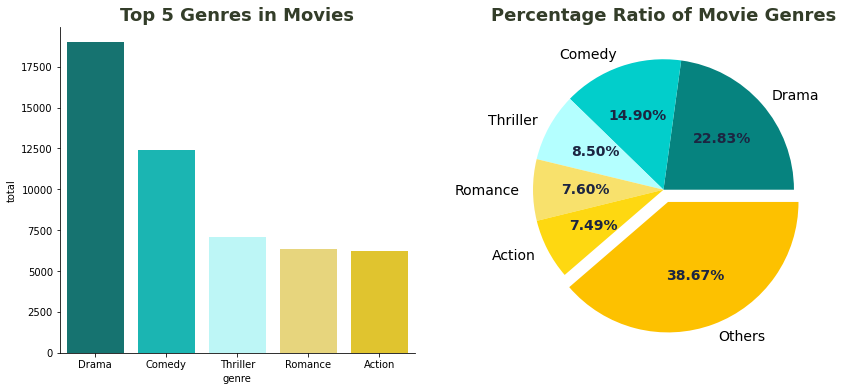

In [ ]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Drama is the most dominant genre with over 18000 movies
* Out of 5 top genres, there are still many genres in the dataset. They hold 38.67% of total genres in the movies

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 6</b></h1>

Text(0.5, 1.0, 'Total Released Movie by Date')

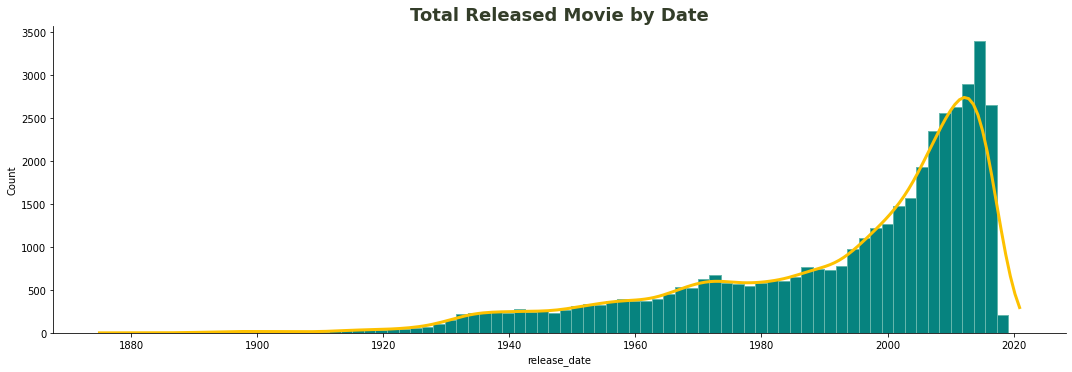

In [ ]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Started from 1930, movies industry had grown significantly from 50 years ago
* A drop in total released movies around 2020 is because the dataset only contains a few data in those years

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 7</b></h1>

In [ ]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))

spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))

crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))

country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

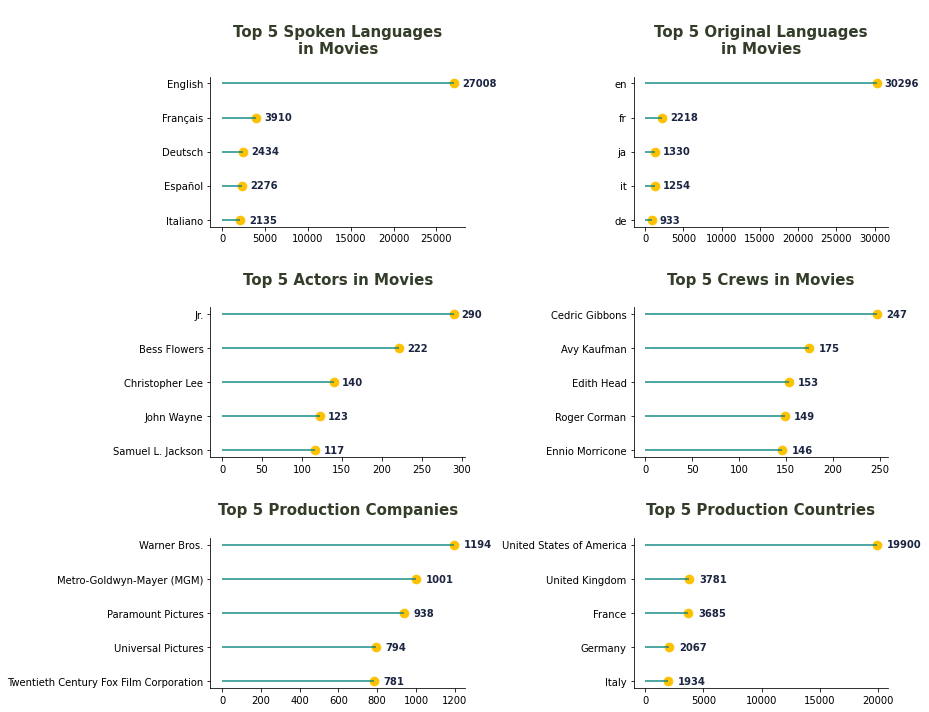

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

sns.despine()
plt.tight_layout()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* For this particular dataset, english is on top of the list for the original and spoken language in the movies
* Jr. and Cedric Gibbons are actor and crew involved in the most movies in the list respectively
* Warner Bros. with 1194 movies make it become top 1 production company in the list
* Many great production companies come from USA. So, it's not a surprise if USA is become our top 1 for production country

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 8</b></h1>

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

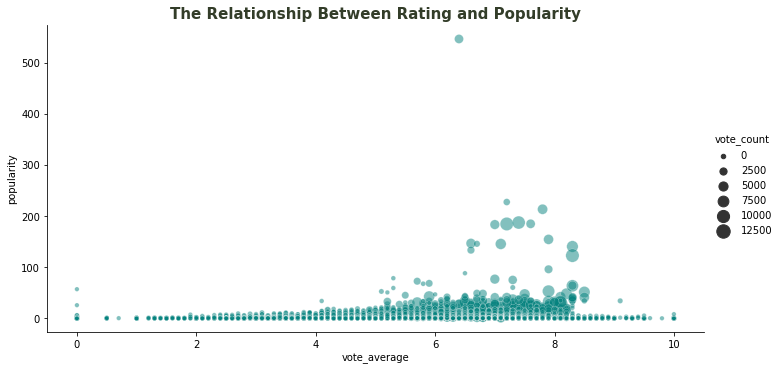

In [ ]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Movies that either got rating 0 or 10 are basically caused by small number of voter. As the vote count increase, the rating is most likely around 5 to 8.5
* It's clear that popular movies will get more vote count as shown from above plot

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 9</b></h1>

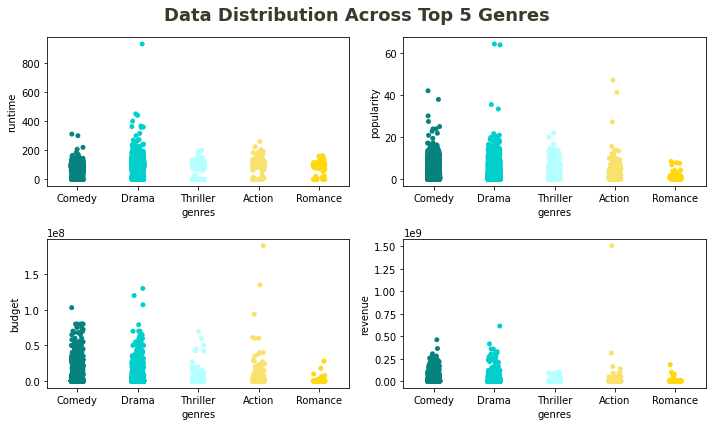

In [ ]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* The movie genre that has the longest runtime is drama
* The least popular genre in the top 5 is romance
* Action movies spent more money than the rest of the movies
* One of the action movies got a vast profit compared to the others

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 10</b></h1>

<AxesSubplot:title={'center':'Correlation of Movie Features\n'}>

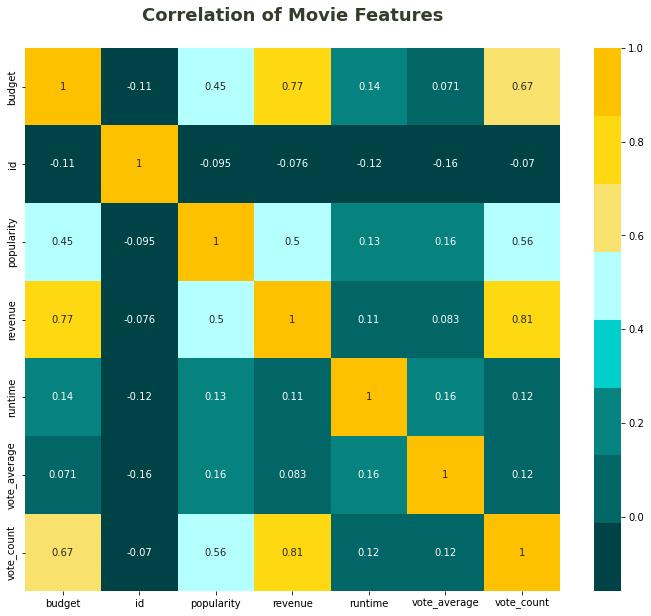

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Vote count, budget, and popularity are 3 dominant features that will determined the revenue of the movies

<a id=2 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Recommender System</p>

There are lots of methods that you can use to build recommender system. This time, we are going to explore two of them from which you can create build recommender system that can give an output of a recommended movies to the users based on different features

<a id=3 a/>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Content-Based</b></h1>

For those of you who have been learning recommender system for a while, you might be familiar with weighted average. The idea behind it is to give a "fair" rating for each movie. For this particular notebook, we will take it to the next level with the help of bag of words

If you see the dataset we had, there are tons of valuable information such as genre, overview, etc. Later, we are going to use this information to make our recommender system more robust. we extract those information inside bag of words then combined it with weighted average to get the final similarity for the movies

![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/06/bayesianParameter.jpg.jpg)

In [ ]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

People watch a movie not just because they see a good rating for that movie, but also because of the hype of certain movie. So, in this case, put popularity into a consideration is a wise choice

Let's take **40% weight for weigthed average** and **60% weight for popularity** considering people don't want to miss a hype movie even the reviews and ratings are poor. You can play around with the number. Next up, we create a new column called score which stores the result

In [ ]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [ ]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


We already got the first result of our recommender system, but we don't stop right here

As mentioned earlier, we will combine those score with the similarity score

In [ ]:
content_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [ ]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [ ]:
content_df['adult'] = content_df['adult'].apply(remove_punc)
content_df['genres'] = content_df['genres'].apply(remove_punc)
content_df['overview'] = content_df['overview'].apply(remove_punc)
content_df['production_companies'] = content_df['production_companies'].apply(separate)
content_df['tagline'] = content_df['tagline'].apply(remove_punc)
content_df['keywords'] = content_df['keywords'].apply(separate)
content_df['crew'] = content_df['crew'].apply(separate)
content_df['characters'] = content_df['characters'].apply(separate)
content_df['actors'] = content_df['actors'].apply(separate)

content_df['bag_of_words'] = ''
content_df['bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df[['bag_of_words']]
content_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


A common method to find similarity between 2 movies is a method called cosine similarity. There are of course a bunch of methods that you can try such as euclidean and sigmoidto know which one performs best

However, calculate similarity for all the movies require an expensive resources. So, because we have limited memory, we only take the first 10000 movies from `weighted_df_sorted`

In [ ]:
content_df = weighted_df_sorted[:10000].merge(content_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(content_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [ ]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [ ]:
content_df.head()

,popularity,weighted_average,score,bag_of_words
original_title,,,,
Minions,1.000000,0.603532,0.841413,false family animation adventure comedy minion...
Big Hero 6,0.390602,0.827561,0.565386,false adventure family animation action comedy...
Baby Driver,0.416507,0.727736,0.540998,false action crime after being coerced into wo...
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054,false action adventure comedy science fiction ...
Pulp Fiction,0.257449,0.908395,0.517827,false thriller crime a burgerloving hit man hi...


In [ ]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T

    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight

    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [ ]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.537320,0.471460
Toy Story 3,0.336500,0.274778,0.293295
Toy Story of Terror!,0.282269,0.294860,0.291082
Small Fry,0.256223,0.271028,0.266586
Hawaiian Vacation,0.266277,0.263819,0.264556
Minions,0.841413,0.005376,0.256187
Finding Nemo,0.346185,0.203631,0.246397
WALL·E,0.348682,0.196733,0.242317


In [ ]:
# content_df.to_csv('content_df.csv')

In [ ]:
# import pickle
# pickle.dump(tfidf_matrix, open('cosine_similarity.pkl', 'wb'))

<a id=4 a/>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Deep Learning</b></h1>

Tensorflow comes with a library called TensorFlow Recommenders (TFRS) for building a recommender system. It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

This time, we use multi-objective approach that applies both implicit (movie watches) and explicit signals (ratings). In the end, we can predict what movies should the user watch along with the given rating corresponds to historical data

In [ ]:
ratings_df = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [ ]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [ ]:
ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [ ]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 43188


In [ ]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


In [ ]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])

    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [ ]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 59s 2s/step - root_mean_squared_error: 1.4245 - factorized_top_k/top_1_categorical_accuracy: 4.5714e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0085 - factorized_top_k/top_10_categorical_accuracy: 0.0209 - factorized_top_k/top_50_categorical_accuracy: 0.1057 - factorized_top_k/top_100_categorical_accuracy: 0.1737 - loss: 6811.5769 - regularization_loss: 0.0000e+00 - total_loss: 6811.5769
Epoch 2/3
35/35 [==============================] - 53s 2s/step - root_mean_squared_error: 1.0467 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0199 - factorized_top_k/top_10_categorical_accuracy: 0.0454 - factorized_top_k/top_50_categorical_accuracy: 0.2022 - factorized_top_k/top_100_categorical_accuracy: 0.3192 - loss: 6452.7548 - regularization_loss: 0.0000e+00 - total_loss: 6452.7548
Epoch 3/3
35/35 [==============================] - 53s 2s/step - root_mean_squared_error: 1.0017 - fac

In [ ]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

9/9 [==============================] - 10s 951ms/step - root_mean_squared_error: 1.2618 - factorized_top_k/top_1_categorical_accuracy: 1.2213e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0040 - factorized_top_k/top_10_categorical_accuracy: 0.0093 - factorized_top_k/top_50_categorical_accuracy: 0.0383 - factorized_top_k/top_100_categorical_accuracy: 0.0747 - loss: 5731.5455 - regularization_loss: 0.0000e+00 - total_loss: 5731.5455

Retrieval top-100 accuracy: 0.075
Ranking RMSE: 1.262


In [ ]:
# model.save_weights('tfrs.h5')

In [ ]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

Making predictions for a couple of users

In [ ]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. Scary Movie
2. Anatomie de l'enfer
3. The Greatest Story Ever Told
4. Un long dimanche de fiançailles
5. Jezebel


In [ ]:
predict_movie(65, 5)

Top 5 recommendations for user 65:

1. Hard Target
2. The Thomas Crown Affair
3. While You Were Sleeping
4. Lonely Hearts
5. Bean


In [ ]:
predict_movie(420, 5)

Top 5 recommendations for user 420:

1. Adams æbler
2. Neues vom Wixxer
3. Birdman of Alcatraz
4. Doctor Zhivago
5. Escape from New York


In [ ]:
predict_movie(153, 10)

Top 10 recommendations for user 153:

1. Beverly Hills Cop III
2. Roma città aperta
3. Star Trek II: The Wrath of Khan
4. Teenage Mutant Ninja Turtles
5. Sommersturm
6. Broken Flowers
7. True Romance
8. License to Wed
9. American History X
10. Dread


In [ ]:
predict_rating(65,'Star Wars')

Predicted rating for Star Wars: 2.6261425018310547


In [ ]:
predict_rating(123,'License to Wed')

Predicted rating for License to Wed: 3.3201045989990234


So, le't examine **User 123 & 65** from historical data

In [ ]:
ratings_df[ratings_df['userId'] == '123']

,userId,movieId,rating,date,original_title,genres,overview
8053,123,233,4.0,2001-07-01 20:57:06,The Wanderers,Drama,The streets of the Bronx are owned by 60’s you...
8054,123,288,5.0,2001-07-01 19:32:47,High Noon,Western,High Noon is about a recently freed leader of ...
8055,123,407,5.0,2001-07-01 20:57:57,Kurz und schmerzlos,"Drama, Thriller",Three friends get caught in a life of major cr...
8056,123,968,3.0,2001-07-01 20:59:01,Dog Day Afternoon,"Crime, Drama, Thriller",A man robs a bank to pay for his lover's opera...
8057,123,1968,4.0,2001-07-01 19:30:36,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...
8058,123,1976,4.0,2001-07-01 19:31:51,Jezebel,"Drama, Romance","In 1850s Louisiana, the willfulness of a tempe..."
8059,123,2003,4.0,2001-07-01 19:31:51,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
8060,123,2428,5.0,2001-07-01 20:57:06,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
8061,123,2502,5.0,2001-07-01 20:59:01,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...
8062,123,2762,5.0,2001-07-01 20:59:54,Young and Innocent,"Drama, Crime",Derrick De Marney finds himself in a 39 Steps ...


In [ ]:
ratings_df[ratings_df['userId'] == '65']

,userId,movieId,rating,date,original_title,genres,overview
3991,65,260,4.0,1999-12-13 20:56:27,The 39 Steps,"Action, Thriller, Mystery","While on vacation in London, Canadian Richard ..."
3992,65,858,5.0,1999-12-14 05:38:14,Sleepless in Seattle,"Comedy, Drama, Romance",A young boy who tries to set his dad up on a d...
3993,65,909,5.0,1999-12-14 05:47:04,Meet Me in St. Louis,"Comedy, Music, Romance",In the year before the 1904 St Louis World's F...
3994,65,920,2.0,1999-12-13 20:57:40,Cars,"Animation, Adventure, Comedy, Family","Lightning McQueen, a hotshot rookie race car d..."
3995,65,924,4.0,1999-12-14 05:49:31,Dawn of the Dead,"Fantasy, Horror, Action",A group of surviving people take refuge in a s...
3996,65,1278,5.0,1999-12-14 05:47:04,The Dreamers,"Drama, Romance",A young American studying in Paris in 1968 str...
3997,65,1956,3.0,1999-12-14 05:37:14,Gerry,"Mystery, Drama, Adventure",Two friends named Gerry become lost in the des...
3998,65,2064,5.0,1999-12-14 05:46:35,While You Were Sleeping,"Comedy, Drama, Romance",A love story built on a misunderstanding. A tr...
3999,65,2289,4.0,1999-12-14 05:46:35,Cold Mountain,Drama,In this classic story of love and devotion set...
4000,65,5060,5.0,1999-12-14 05:45:51,Carry On Screaming,Comedy,The sinister Dr Watt has an evil scheme going....


In [ ]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,Scary Movie,Comedy,Following on the heels of popular teen-scream ...
2,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
3,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
4,Un long dimanche de fiançailles,Drama,"In 1919, Mathilde was 19 years old. Two years ..."
5,Jezebel,"Drama, Romance","In 1850s Louisiana, the willfulness of a tempe..."


In [ ]:
predict_rating(123,'Minions')

Predicted rating for Minions: 2.6918225288391113


At a glance, we can see if **User 123** love watching Drama movies most of the time. He/She also gives a good rating for that genre. In our recommendation, We give 5 more Drama movies that we expect him/her to love the movies in a similar way with the previous watched movies.

In our dataset, we don't see any Animation movies that have been watched by **User 123**. So, it's not a surprise if the estimated rating for Minions is quite low

In [ ]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['65']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,Hard Target,"Action, Adventure, Crime, Thriller","When a woman's father goes missing, she enlist..."
2,The Thomas Crown Affair,"Drama, Crime, Romance",A very rich and successful playboy amuses hims...
3,While You Were Sleeping,"Comedy, Drama, Romance",A love story built on a misunderstanding. A tr...
4,Lonely Hearts,"Drama, Thriller, Crime, Romance","In the late 1940's, Martha Beck and Raymond Fe..."
5,Bean,Comedy,Bean works as a caretaker at Britain's formida...


In [ ]:
predict_rating(65,'Star Wars')

Predicted rating for Star Wars: 2.6261425018310547


Similarly, we can see if **User 65** love watching Romantic movies most of the time. He/She also gives a good rating for that genre. In our recommendation, We give 3 more Romantic movies that we expect him/her to love the movies in a similar way with the previous watched movies.

In our dataset, we don't see any Science Fiction movies that have been watched by **User 65**. So, it's not a surprise if the estimated rating for Star Wars is quite low

<h1 style="font-family: Trebuchet MS; font-size: 60px; color: #1b4332; text-align: center;"><b>THE END</b></h1>